In [1]:
import os
import time
import pprint
import argparse
import torch
import numpy as np
import pickle
import utils
import csv

from model.hidden import Hidden
from noise_layers.noiser import Noiser
from average_meter import AverageMeter
from noise_argparser import NoiseArgParser

import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

/home/master/10/jimmyliu/miniconda3/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_dir='/tmp2/jimmyliu/HiDDeN_experiment/dataset_10000'
#current_run='/tmp2/jimmyliu/HiDDeN_experiment/ss_HiDDeN/runs/combined-noise-256-adam 2023.05.20--02-44-07'
current_run="/tmp2/jimmyliu/HiDDeN_experiment/ss_HiDDeN/runs/combined-noise-ssbase-256-lamb-mse"
batch_size=2
round=True

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
options_file = os.path.join(current_run, 'options-and-config.pickle')
train_options, hidden_config, _ = utils.load_options(options_file)
train_options.train_folder = os.path.join(data_dir, 'val')
train_options.validation_folder = os.path.join(data_dir, 'train')
train_options.batch_size = batch_size
noise_config=[]

In [4]:
checkpoint, chpt_file_name = utils.load_last_checkpoint(os.path.join(current_run, 'checkpoints'))
print(f'Loaded checkpoint from file {chpt_file_name}')

noiser = Noiser(noise_config,device)
model = Hidden(hidden_config, device, noiser, tb_logger=None,train_options=train_options)
utils.model_from_checkpoint(model, checkpoint)
model.encoder_decoder.eval()

Loaded checkpoint from file /tmp2/jimmyliu/HiDDeN_experiment/ss_HiDDeN/runs/combined-noise-ssbase-256-lamb-mse/checkpoints/combined-noise-ssbase-256-lamb--epoch-33.pyt


EncoderDecoder(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): ConvBNRelu(
        (layers): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (1): ConvBNRelu(
        (layers): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (2): ConvBNRelu(
        (layers): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (3): ConvBNRelu(
        (layers): Sequential(
          (0): Conv2d(64, 64, kernel

In [5]:
_, val_data = utils.get_data_loaders(hidden_config, train_options)
file_count = len(val_data.dataset)
if file_count % train_options.batch_size == 0:
            steps_in_epoch = file_count // train_options.batch_size
else:
    steps_in_epoch = file_count // train_options.batch_size + 1

In [6]:
print(file_count)

10000


In [7]:

step = 0
losses_accu={}

ori_list_arr=[]
with torch.no_grad():
    for image, _ in val_data:
        
        image = image.to(device)
        #message = torch.Tensor(np.random.choice([0, 1], (image.shape[0], hidden_config.message_length))).to(device)
        decoded_messages= model.encoder_decoder.decoder(image)
        #decoded_messages=torch.sigmoid(decoded_messages)
        if step==0:
            ori_list_arr=decoded_messages.detach().cpu()
        else:
            ori_list_arr=torch.cat( (ori_list_arr,decoded_messages.detach().cpu()),0 )



        step += 1
        '''
        if step >=2:
            break
        '''

In [8]:

if round:
    ruond_ori_list_arr=ori_list_arr.round().clip(0, 1)

miu=torch.mean(ori_list_arr, 0)
round_miu=torch.mean(ruond_ori_list_arr, 0)

In [9]:
print(miu.mean())
print(round_miu.mean())
print(miu)
print(round_miu)

tensor(0.4972)
tensor(0.4694)
tensor([0.4905, 0.3175, 0.4683, 0.5550, 0.4155, 0.4560, 0.5113, 0.6391, 0.4805,
        0.5412, 0.4551, 0.4439, 0.3279, 0.5935, 0.3422, 0.4151, 0.2634, 0.0642,
        0.6811, 0.7225, 0.2623, 0.7409, 0.6245, 0.5680, 0.3766, 0.4671, 0.2976,
        0.5321, 0.2388, 0.5983, 0.3923, 0.8588, 0.1657, 0.5379, 0.7835, 0.7173,
        0.3393, 0.4342, 0.5104, 1.0114, 0.7551, 0.6477, 0.2540, 0.8568, 0.5610,
        0.4677, 0.2591, 0.4250])
tensor([0.4603, 0.0785, 0.3588, 0.5888, 0.2176, 0.3243, 0.5239, 0.8104, 0.4987,
        0.6509, 0.3514, 0.2822, 0.0501, 0.8125, 0.1330, 0.3042, 0.0133, 0.0168,
        0.9391, 0.8700, 0.0118, 0.9917, 0.8795, 0.6958, 0.1344, 0.4497, 0.0608,
        0.6035, 0.0410, 0.7047, 0.1165, 0.9950, 0.0152, 0.6445, 0.9622, 0.9105,
        0.0691, 0.2704, 0.5657, 0.9976, 0.8447, 0.8776, 0.0245, 0.9792, 0.6107,
        0.4244, 0.0888, 0.2776])


In [10]:
ori_list_arr

tensor([[ 0.5526,  0.1120,  0.5735,  ...,  0.6703, -0.0351,  0.2662],
        [ 0.4946,  0.2643,  0.5516,  ...,  0.5539,  0.1350,  0.3549],
        [ 0.5043,  0.3025,  0.4589,  ...,  0.5380,  0.1881,  0.5418],
        ...,
        [ 0.4695,  0.2437,  0.5789,  ...,  0.4505,  0.0905,  0.5152],
        [ 0.4619,  0.5007,  0.5613,  ...,  0.6340,  0.2612,  0.5158],
        [ 0.4864,  0.1927,  0.3360,  ...,  0.3155,  0.3564,  0.7367]])

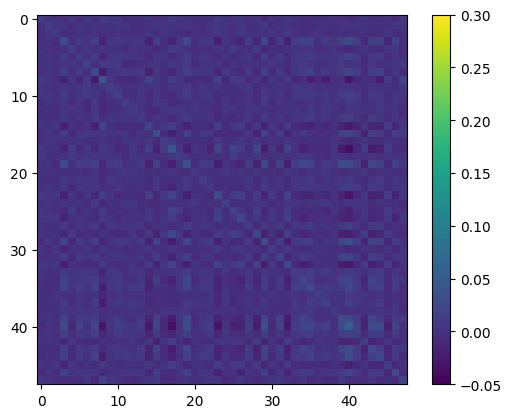

In [11]:
conv_matrix=torch.cov(ori_list_arr.T)

#plt.matshow(conv_matrix, cmap=plt.cm.Blues)
plt.imshow(conv_matrix,vmin=-0.05,vmax=0.3)
plt.colorbar()

plt.show()



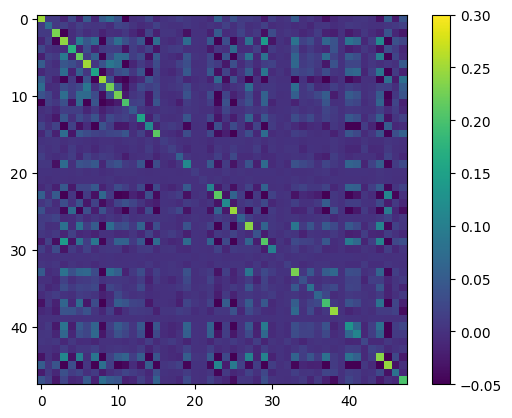

In [12]:
round_conv_matrix=torch.cov(ruond_ori_list_arr.T)

#plt.matshow(conv_matrix, cmap=plt.cm.Blues)
plt.imshow(round_conv_matrix,vmin=-0.05,vmax=0.3)
plt.colorbar()

plt.show()

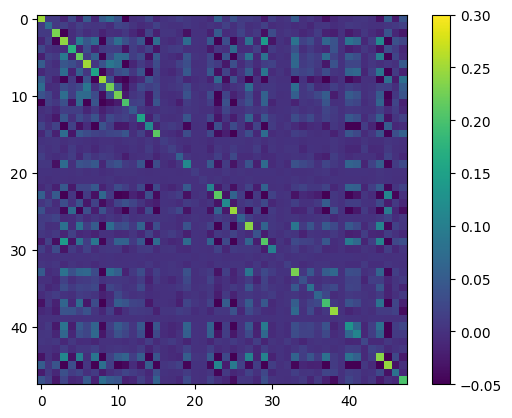

In [13]:
round_conv_matrix=torch.cov((ruond_ori_list_arr-miu).T)

#plt.matshow(conv_matrix, cmap=plt.cm.Blues)
plt.imshow(round_conv_matrix,vmin=-0.05,vmax=0.3)
plt.colorbar()

plt.show()

In [14]:
print(round_conv_matrix.T == round_conv_matrix)

tensor([[ True,  True,  True,  ...,  True, False,  True],
        [ True,  True,  True,  ..., False,  True, False],
        [ True,  True,  True,  ...,  True,  True, False],
        ...,
        [ True, False,  True,  ...,  True,  True,  True],
        [False,  True,  True,  ...,  True,  True,  True],
        [ True, False, False,  ...,  True,  True,  True]])


In [15]:
conv_matrix=(conv_matrix.T+conv_matrix)/2
print(torch.all(conv_matrix.T == conv_matrix))

tensor(True)


In [16]:
L, V = torch.linalg.eig(conv_matrix)
#L, V = torch.linalg.eigh(conv_matrix)
L_matrix=torch.diag_embed(1/torch.sqrt(L))
#b=-(L_matrix@V.T).to(torch.float)@(
# 
# -0.5)
b=-(L_matrix@V.T).to(torch.float)@miu
w=(L_matrix@V.T).to(torch.float)

eig_whitening_layer=nn.Linear(48,48)
eig_whitening_layer.weight=nn.Parameter(w)
eig_whitening_layer.bias=nn.Parameter(b)
eig_whitening_layer=eig_whitening_layer.to(device)
eig_whitening_layer.eval()

/tmp/ipykernel_72258/2519530637.py:5: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Copy.cpp:239.)
  b=-(L_matrix@V.T).to(torch.float)@miu


Linear(in_features=48, out_features=48, bias=True)

In [17]:
#L, V = torch.linalg.eig(conv_matrix)
L, V = torch.linalg.eigh(conv_matrix)
L_matrix=torch.diag_embed(1/torch.sqrt(L))

#b=-(L_matrix@V.T).to(torch.float)@(miu-0.5)
b=-(L_matrix@V.T)@miu
w=(L_matrix@V.T)

eigh_whitening_layer=nn.Linear(48,48)
eigh_whitening_layer.weight=nn.Parameter(w)
eigh_whitening_layer.bias=nn.Parameter(b)
eigh_whitening_layer=eigh_whitening_layer.to(device)
eigh_whitening_layer.eval()

Linear(in_features=48, out_features=48, bias=True)

In [18]:
print(L)

tensor([1.2863e-07, 1.3228e-07, 5.0312e-07, 1.3369e-06, 2.2928e-06, 7.6729e-06,
        1.0101e-05, 2.4272e-05, 6.3781e-05, 1.2274e-03, 1.3654e-03, 1.5508e-03,
        1.6905e-03, 1.9869e-03, 2.0619e-03, 2.1313e-03, 2.3809e-03, 2.5734e-03,
        2.5857e-03, 2.8860e-03, 2.9218e-03, 3.1790e-03, 3.2800e-03, 3.5865e-03,
        3.8234e-03, 4.1642e-03, 4.2857e-03, 4.8794e-03, 5.0396e-03, 5.7567e-03,
        6.2060e-03, 7.5290e-03, 7.5701e-03, 8.4203e-03, 9.1451e-03, 1.0081e-02,
        1.1824e-02, 1.4008e-02, 1.9099e-02, 2.3121e-02, 2.6957e-02, 3.4784e-02,
        3.9181e-02, 4.9334e-02, 6.3018e-02, 8.9777e-02, 1.2948e-01, 4.0531e-01])


In [29]:

step = 0
losses_accu={}

eig_list_arr=[]

eigh_list_arr=[]
with torch.no_grad():
    for image, _ in val_data:
        
        image = image.to(device)
        #message = torch.Tensor(np.random.choice([0, 1], (image.shape[0], hidden_config.message_length))).to(device)
        decoded_messages= model.encoder_decoder.decoder(image)
        #decoded_messages=torch.sigmoid(decoded_messages)
        eig_decoded_messages=eig_whitening_layer(decoded_messages)
        eigh_decoded_messages=eigh_whitening_layer(decoded_messages)


        if step==0:
            eig_list_arr=eig_decoded_messages.detach().cpu()
            eigh_list_arr=eigh_decoded_messages.detach().cpu()
        else:
            eig_list_arr=torch.cat( (eig_list_arr,eig_decoded_messages.detach().cpu()),0 )
            eigh_list_arr=torch.cat( (eigh_list_arr,eigh_decoded_messages.detach().cpu()),0 )



        step += 1
       

In [30]:
print(decoded_messages)

tensor([[ 0.4619,  0.5007,  0.5613,  0.5745,  0.3963,  0.4751,  0.5579,  0.6417,
          0.7129,  0.6513,  0.4469,  0.4290,  0.3160,  0.6871,  0.4480,  0.5803,
          0.4177,  0.1540,  0.6805,  0.8347,  0.2853,  0.6816,  0.6531,  0.8289,
          0.3098,  0.3767,  0.4913,  0.6832,  0.2916,  0.6257,  0.4323,  0.8298,
          0.3639,  0.4767,  0.7450,  0.7349,  0.3696,  0.4418,  0.6469,  0.9633,
          0.6463,  0.6121,  0.1215,  0.7388,  0.5503,  0.6340,  0.2612,  0.5158],
        [ 0.4864,  0.1927,  0.3360,  0.4927,  0.3153,  0.3297,  0.3657,  0.4160,
          0.8036,  0.5161,  0.3629,  0.4825,  0.2384,  0.8377,  0.4999,  0.7538,
          0.2100, -0.2293,  0.3904,  0.7671,  0.3036,  0.7546,  0.6575,  0.4671,
          0.2851,  0.1571,  0.3002,  0.4283, -0.0231,  0.6224,  0.4565,  0.8657,
          0.0995,  0.5543,  0.7873,  0.5346,  0.2704,  0.4834,  0.3946,  1.0230,
          0.8206,  0.6086,  0.1680,  0.9681,  0.4177,  0.3155,  0.3564,  0.7367]],
       device='cuda:0')


In [31]:
print(eig_decoded_messages)

tensor([[-0.3371,  0.5635,  0.2697, -1.3705,  1.1225,  0.6492,  0.6824, -0.2810,
          0.8370, -0.6709,  1.5827, -1.3215, -0.6804, -0.4774,  1.5575, -0.3696,
         -0.2324, -0.2597, -0.0747, -1.2940,  1.4832,  1.5205, -2.6050, -0.3604,
         -0.8400, -0.5638, -0.1755, -0.4263,  0.9378,  0.2230,  1.9231,  0.5420,
          1.1033, -0.2389, -1.9205,  0.1466, -0.3803,  1.1050, -0.3114, -0.2348,
         -0.4014, -1.3194, -0.7796,  2.0215, -1.2931, -0.8039,  0.6389,  0.2250],
        [ 0.2157,  1.6248, -1.9279,  0.5386, -0.3984,  0.9407,  1.0754, -0.8918,
         -1.7918, -0.8193,  1.5434, -1.7651, -0.5516, -1.9788, -1.1786,  1.3783,
          0.4969, -0.0919, -0.7570,  0.8762,  0.3270,  0.3509,  0.6779,  0.2745,
          0.0799,  0.4516,  0.1934,  0.4116, -1.1301,  0.2806, -0.9664,  1.1525,
         -0.0267,  0.8124,  1.4614, -0.5800, -0.2570, -0.6349, -0.6564,  2.2028,
         -0.1830, -0.4514,  0.4856,  0.4329,  0.1253,  1.0995, -0.5567,  0.7623]],
       device='cuda:0')


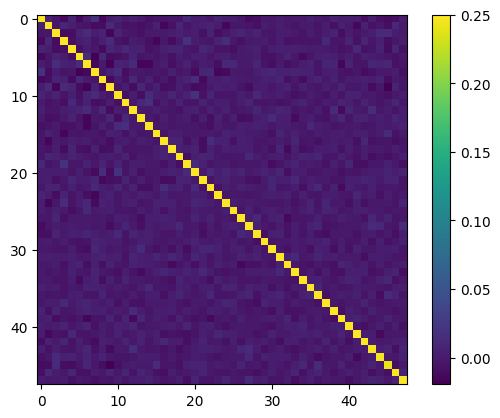

In [32]:
noround_eig_miu=torch.mean(eig_list_arr, 0)
noround_eigh_miu=torch.mean(eigh_list_arr, 0)

eig_list_arr=eig_list_arr/2+0.5
eigh_list_arr=eigh_list_arr/2+0.5
if round:
    eig_list_arr=eig_list_arr.round().clip(0, 1)
    eigh_list_arr=eigh_list_arr.round().clip(0, 1)

eig_conv_matrix=torch.cov((eig_list_arr).T)
plt.imshow(eig_conv_matrix)
plt.colorbar()

plt.show()

In [33]:
print(torch.diag(eig_conv_matrix))

tensor([0.2500, 0.2498, 0.2495, 0.2499, 0.2500, 0.2497, 0.2490, 0.2500, 0.2491,
        0.2496, 0.2486, 0.2500, 0.2500, 0.2500, 0.2497, 0.2500, 0.2498, 0.2499,
        0.2499, 0.2499, 0.2496, 0.2500, 0.2498, 0.2500, 0.2497, 0.2500, 0.2500,
        0.2500, 0.2500, 0.2500, 0.2499, 0.2500, 0.2500, 0.2500, 0.2499, 0.2500,
        0.2500, 0.2496, 0.2500, 0.2496, 0.2499, 0.2500, 0.2500, 0.2463, 0.2468,
        0.2417, 0.2484, 0.2480])


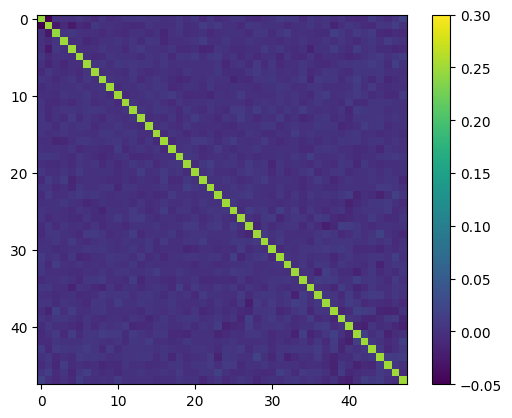

In [34]:
eigh_conv_matrix=torch.cov((eigh_list_arr).T)
plt.imshow(eigh_conv_matrix,vmin=-0.05,vmax=0.3)
plt.colorbar()

plt.show()

In [35]:
print(torch.diag(eigh_conv_matrix))
print(torch.diag(eig_conv_matrix))

tensor([0.2449, 0.2499, 0.2441, 0.2493, 0.2491, 0.2499, 0.2500, 0.2500, 0.2488,
        0.2500, 0.2500, 0.2500, 0.2499, 0.2500, 0.2499, 0.2500, 0.2500, 0.2497,
        0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2497, 0.2500, 0.2498, 0.2500,
        0.2497, 0.2499, 0.2499, 0.2499, 0.2498, 0.2500, 0.2497, 0.2500, 0.2500,
        0.2500, 0.2486, 0.2496, 0.2491, 0.2500, 0.2490, 0.2497, 0.2500, 0.2499,
        0.2495, 0.2498, 0.2500])
tensor([0.2500, 0.2498, 0.2495, 0.2499, 0.2500, 0.2497, 0.2490, 0.2500, 0.2491,
        0.2496, 0.2486, 0.2500, 0.2500, 0.2500, 0.2497, 0.2500, 0.2498, 0.2499,
        0.2499, 0.2499, 0.2496, 0.2500, 0.2498, 0.2500, 0.2497, 0.2500, 0.2500,
        0.2500, 0.2500, 0.2500, 0.2499, 0.2500, 0.2500, 0.2500, 0.2499, 0.2500,
        0.2500, 0.2496, 0.2500, 0.2496, 0.2499, 0.2500, 0.2500, 0.2463, 0.2468,
        0.2417, 0.2484, 0.2480])


In [36]:
print(noround_eig_miu.mean())
print(noround_eigh_miu.mean())

tensor(-0.0120)
tensor(0.0070)


In [37]:
torch.save(eig_whitening_layer,'eig.pt')

In [38]:
eig_whitening_layer=torch.load('eig.pt')